In [60]:
import collections
import dataclasses

import networkx as nx
import pandas as pd
import seaborn as sns

from scripture_graph import graph_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [24]:
graph = nx.read_graphml('../../scripture_graph.graphml')

In [77]:
# Count the fraction of reciprocal references...there seem to be a lot of them.
unique = []
for a, b in graph.edges:
    if (b, a) not in graph.edges:
        unique.append((a, b))
print(len(unique), len(graph.edges), len(unique) / len(graph.edges), 1 - len(unique) / len(graph.edges))

8020 45880 0.17480383609415867 0.8251961639058414


# Reference Counts

In [101]:
len(graph.nodes)

41995

In [102]:
len(graph.edges)

45880

In [78]:
rows = []
# NOTE(kearnes): We are only considering "in" references.
for node, degree in graph.in_degree():
    row = {'node': node, 'degree': degree}
    row.update(graph.nodes[node])
    rows.append(row)
df = pd.DataFrame(rows)
print(df.shape)
df.head()

(41995, 6)


,node,degree,volume,book,chapter,verse
0,1 Chr. 1:1,0,Old Testament,1 Chr.,1,1
1,1 Chr. 1:2,0,Old Testament,1 Chr.,1,2
2,1 Chr. 1:3,0,Old Testament,1 Chr.,1,3
3,1 Chr. 1:4,2,Old Testament,1 Chr.,1,4
4,1 Chr. 1:5,0,Old Testament,1 Chr.,1,5


In [80]:
alone = (df.degree == 0).sum()
alone / len(df)

0.5576378140254792

In [81]:
count = (df.degree >= 1) & (df.degree <= 5)
count.sum() / len(df)

0.4071913323014645

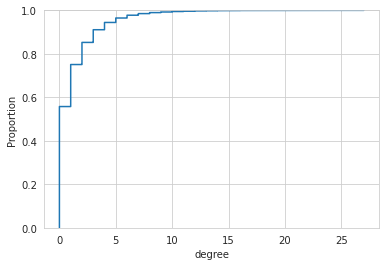

In [94]:
sns.set_style('whitegrid')

fig, ax = subplots()
sns.ecdfplot(data=df, x='degree', ax=ax)
fig.savefig('count-cdf.png', dpi=300, bbox_inches='tight')

In [100]:
sort = df.sort_values('degree', ascending=False)
for volume in sort.volume.unique():
    print(sort[sort.volume == volume].head())

            node  degree                  volume book  chapter  verse
36839   D&C 17:1      27  Doctrine and Covenants  D&C       17      1
35494   D&C 1:38      27  Doctrine and Covenants  D&C        1     38
35470   D&C 1:14      24  Doctrine and Covenants  D&C        1     14
38772  D&C 88:63      21  Doctrine and Covenants  D&C       88     63
35472   D&C 1:16      21  Doctrine and Covenants  D&C        1     16
              node  degree          volume   book  chapter  verse
31384  1 Ne. 17:35      25  Book of Mormon  1 Ne.       17     35
39664    Hel. 12:3      25  Book of Mormon   Hel.       12      3
32109  2 Ne. 25:20      23  Book of Mormon  2 Ne.       25     20
31439  1 Ne. 19:10      23  Book of Mormon  1 Ne.       19     10
32472   2 Ne. 9:28      20  Book of Mormon  2 Ne.        9     28
             node  degree                volume   book  chapter  verse
41051  Moses 6:57      23  Pearl of Great Price  Moses        6     57
40811   Moses 1:6      18  Pearl of Great 

# Reference Patterns

In [10]:
# Look at pairs of standard works (or even books). What are the cross-reference patterns?

# TODO:
# * Compare to normalization by the number of verses (relative reference propensity). The absolute is interesting too.

In [43]:
volume_counts = collections.defaultdict(int)
book_counts = collections.defaultdict(int)
for tail in graph.nodes:
    tail_volume = graph.nodes[tail]['volume']
    tail_book = graph.nodes[tail]['book']
    for head, _ in graph.in_edges(tail):
        head_volume = graph.nodes[head]['volume']
        head_book = graph.nodes[head]['book']
        volume_counts[(head_volume, tail_volume)] += 1
        book_counts[(head_book, tail_book)] += 1

rows = []
for (head, tail), count in volume_counts.items():
    rows.append({'head': head, 'tail': tail, 'count': count})
volume_data = pd.DataFrame(rows)
print(volume_data.head())
        
rows = []
for (head, tail), count in book_counts.items():
    rows.append({'head': head, 'tail': tail, 'count': count})
book_data = pd.DataFrame(rows)
print(book_data.head())

                     head           tail  count
0           Old Testament  Old Testament  11244
1    Pearl of Great Price  Old Testament    369
2          Book of Mormon  Old Testament   2435
3  Doctrine and Covenants  Old Testament   1840
4           New Testament  Old Testament   1098
     head    tail  count
0    Gen.  1 Chr.     31
1   Moses  1 Chr.      3
2   Ether  1 Chr.      2
3    Abr.  1 Chr.      1
4  1 Sam.  1 Chr.     19


<AxesSubplot:xlabel='head', ylabel='tail'>

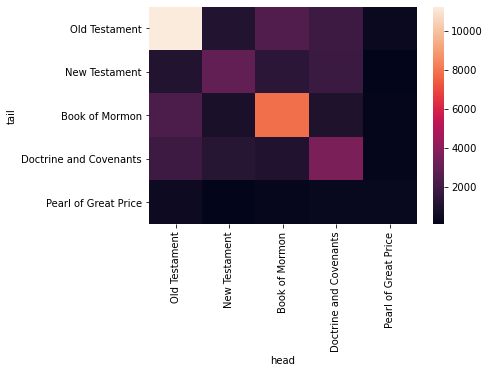

In [58]:
order = []
for volume in graph_lib.VOLUMES.keys():
    if volume == 'Study Helps':
        continue
    order.append(volume)
df = volume_data.pivot('tail', 'head', 'count').reindex(index=order, columns=order)
sns.heatmap(df)

<AxesSubplot:xlabel='head', ylabel='tail'>

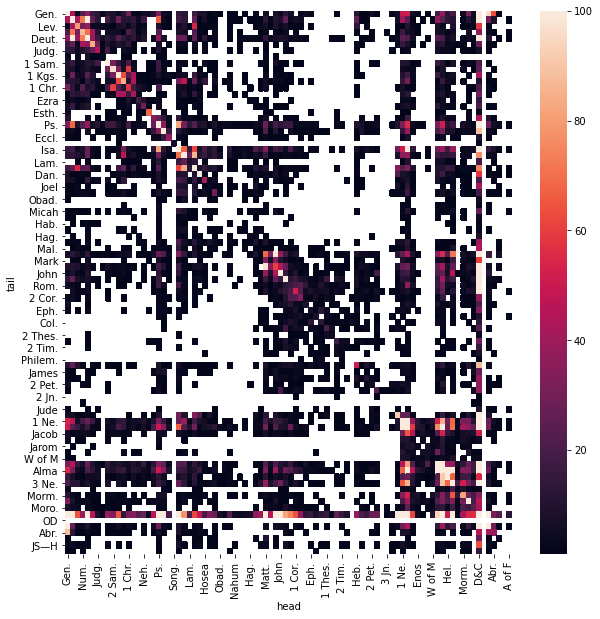

In [66]:
order = []
for volume, books in graph_lib.VOLUMES.items():
    if volume == 'Study Helps':
        continue
    order.extend(books)
df = book_data.pivot('tail', 'head', 'count').reindex(index=order, columns=order)
figure(figsize=(10, 10))
sns.heatmap(df, vmax=100)